In [1]:
import os
import sys
import random 

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt 
import albumentations as albu

sys.path.append("..")

from IPython import display

# %load_ext autoreload
# %autoreload 2

In [2]:
# sys.path.append("/home/zakirov/repoz/metrics-comparison/")
# sys.path.append("../")

## Download datasets

In [3]:
# mnist = torchvision.datasets.MNIST("../datasets", train=True, download=True)
# cifar10 = torchvision.datasets.CIFAR10("../datasets", download=True)
# cifar100 = torchvision.datasets.CIFAR100("../datasets", download=True)

In [4]:
# !wget -P datasets/ http://cs231n.stanford.edu/tiny-imagenet-200.zip
# !wget -P datasets/ http://vllab.ucmerced.edu/wlai24/LapSRN/results/SR_testing_datasets.zip
# !wget -P datasets/ http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip
# !wget -P datasets/ http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip
# !wget -P datasets/ http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip

## Test datasets

In [6]:
from src.augmentations import get_aug
from src.utils import walk_files
from src.datasets import *
from torch.utils.data import Dataset

In [7]:
transform = get_aug(aug_type="light", task="deblur", size=128)
target_transform =  get_aug("val", None, size=128)

tiny = TinyImageNet(train=True, transform=transform)
mnist = MNIST(root="datasets/", train=True, transform=transform)
cifar10 = CIFAR10(root="datasets/", train=True, transform=transform)
cifar100 = CIFAR100(root="datasets/", train=True, transform=transform)
div2k = DIV2KDataset(train=False, transform=transform)
set5 = Set5(train=False, transform=transform)
set14 = Set14(train=False, transform=transform)
urban100 = Urban100(train=False, transform=transform)
manga109 = Manga109(train=False, transform=transform)
bsds100 = BSDS100(train=False, transform=transform)

datasets = [tiny, mnist, cifar10, cifar100, div2k, set5, set14, urban100, manga109, bsds100]

datasets/DIV2K_valid_LR_bicubic/X2


Input torch.Size([3, 128, 128]) tensor(0.0314) tensor(0.9176)
Target torch.Size([3, 128, 128]) tensor(0.) tensor(0.9922)


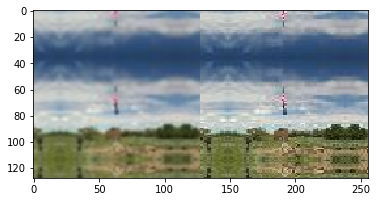

Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets/
    Split: Train
    StandardTransform
Transform: Compose([
             Compose([
               PadIfNeeded(always_apply=False, p=1.0, min_height=128, min_width=128, border_mode=4, value=None, mask_value=None),
               RandomResizedCrop(always_apply=False, p=1.0, height=128, width=128, scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1),
             ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
             OneOf([
               Blur(always_apply=False, p=0.5, blur_limit=(3, 5)),
               GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 5)),
             ], p=1.0),
             Compose([
               Normalize(always_apply=False, p=1.0, mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), max_pixel_value=255.0),
               ToTensorV2(always_apply=True, p=1.0),
             ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={'mask':

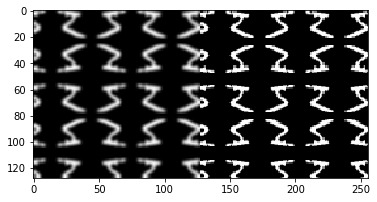

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: datasets/
    Split: Train
    StandardTransform
Transform: Compose([
             Compose([
               PadIfNeeded(always_apply=False, p=1.0, min_height=128, min_width=128, border_mode=4, value=None, mask_value=None),
               RandomResizedCrop(always_apply=False, p=1.0, height=128, width=128, scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1),
             ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
             OneOf([
               Blur(always_apply=False, p=0.5, blur_limit=(3, 5)),
               GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 5)),
             ], p=1.0),
             Compose([
               Normalize(always_apply=False, p=1.0, mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), max_pixel_value=255.0),
               ToTensorV2(always_apply=True, p=1.0),
             ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={'mask

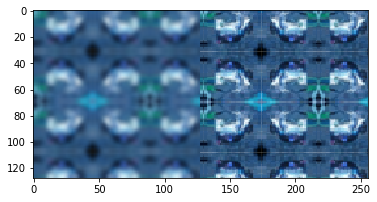

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: datasets/
    Split: Train
    StandardTransform
Transform: Compose([
             Compose([
               PadIfNeeded(always_apply=False, p=1.0, min_height=128, min_width=128, border_mode=4, value=None, mask_value=None),
               RandomResizedCrop(always_apply=False, p=1.0, height=128, width=128, scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1),
             ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
             OneOf([
               Blur(always_apply=False, p=0.5, blur_limit=(3, 5)),
               GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 5)),
             ], p=1.0),
             Compose([
               Normalize(always_apply=False, p=1.0, mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), max_pixel_value=255.0),
               ToTensorV2(always_apply=True, p=1.0),
             ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={'mas

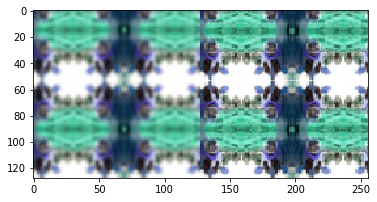

Input torch.Size([3, 128, 128]) tensor(0.0118) tensor(0.9843)
Target torch.Size([3, 128, 128]) tensor(0.) tensor(1.)


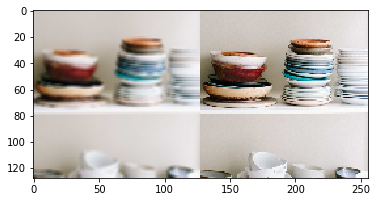

Input torch.Size([3, 128, 128]) tensor(0.0157) tensor(0.9843)
Target torch.Size([3, 128, 128]) tensor(0.0157) tensor(0.9922)


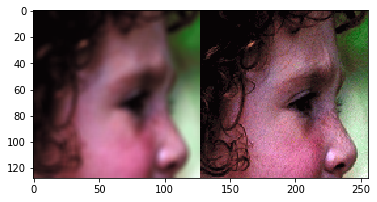

Input torch.Size([3, 128, 128]) tensor(0.) tensor(0.8902)
Target torch.Size([3, 128, 128]) tensor(0.) tensor(0.9216)


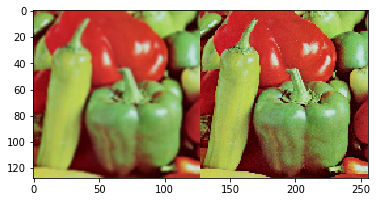

Input torch.Size([3, 128, 128]) tensor(0.0353) tensor(1.)
Target torch.Size([3, 128, 128]) tensor(0.) tensor(1.)


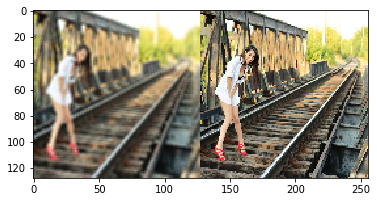

Input torch.Size([3, 128, 128]) tensor(0.1333) tensor(1.)
Target torch.Size([3, 128, 128]) tensor(0.) tensor(1.)


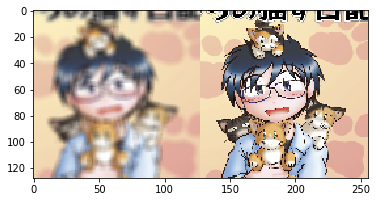

Input torch.Size([3, 128, 128]) tensor(0.1216) tensor(1.)
Target torch.Size([3, 128, 128]) tensor(0.0902) tensor(1.)


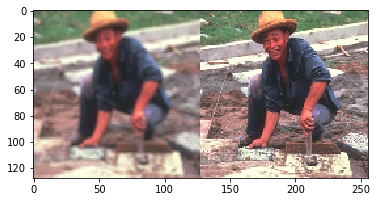

In [8]:
for dataset in datasets:
    print(dataset)
    input, target = dataset[0]
    print("Input", input.shape, input.min(), input.max())
    print("Target", target.shape, target.min(), target.max())
    plt.imshow(torch.cat([input, target], dim=2).permute(1, 2, 0))
    plt.show()
    

torch.Size([512, 512, 3]) torch.Size([3, 512, 512]) tensor(0.) tensor(1.)


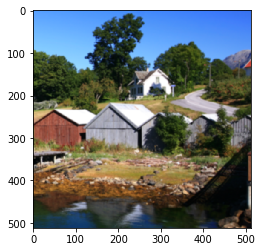

In [101]:
# input, target = dataset[20]
print(target.shape, input.shape, input.min(), input.max())
plt.imshow(input.transpose(0, 2).transpose(0, 1))

In [112]:
target.permute(2, 0, 1).shape, input.shape

(torch.Size([3, 512, 512]), torch.Size([3, 512, 512]))

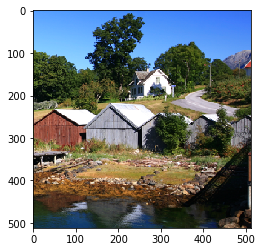

In [113]:
plt.imshow(target.permute(2, 0, 1).transpose(0, 2).transpose(0, 1))

In [70]:
dataset = TinyImageNetDataset(train=True, transform=None, target_transform=None)
input, target = dataset[6]
# input.shape
# plt.imshow(input / 255.)
(input / 255.).min(), (input / 255.).max()

(0.0, 1.0)

In [46]:
input.transpose(0, 2).transpose(0, 1).shape

torch.Size([64, 64, 3])

In [37]:
# dataset[0][0].shape

(64, 64, 3)

In [7]:
# from src.augmentations import get_aug
# from src.datasets import MNIST, CIFAR10, CIFAR100
from ..src.datasets
# from src.datasets import get_dataloader

ModuleNotFoundError: No module named 'src.datasets'

In [ ]:
transform = get_aug(aug_type="light", size=32)
target_transform = get_aug(aug_type="val", size=32)
# target_transform = None

In [ ]:
transform, target_transform

In [ ]:
trainset = CIFAR10(root='../datasets', train=True, transform=transform, target_transform=target_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# valset = CIFAR10(root='../datasets', train=False, transform=transform, target_transform=target_transform)
# valloader = torch.utils.data.DataLoader(valset, batch_size=16,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
image, target = trainset[0]
print(image.shape, target.shape)
print(image.max(), image.min())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
input, target = dataiter.next()

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
model = torchvision.models.resnet18(pretrained=True)

model.fc = Identity()
model.to("cpu")

In [ ]:
mock = torch.rand((3, 3, 32, 32))

In [ ]:
result = model(mock)

In [ ]:
all_input_features = [result.detach() for _ in range(4)]
print(len(all_input_features))

In [ ]:
input_features = torch.cat(all_input_features, dim=0)
input_features.shape

In [ ]:
input.shape, target.shape

In [ ]:
class HDRLoss(nn.Module):
    """High dynamic range loss."""

    def __init__(self, eps=0.01):
        """Initializes loss with numerical stability epsilon."""

        super(HDRLoss, self).__init__()
        self._eps = eps


    def forward(self, denoised, target):
        """Computes loss by unpacking render buffer."""

        loss = ((denoised - target) ** 2) / (denoised + self._eps) ** 2
        return loss.mean(dim=[1,2,3])

In [ ]:
hdr = HDRLoss()

In [ ]:
loss = hdr(target+ 0.001, target)
print(loss.shape)

In [ ]:
loss

In [ ]:
# show images
print(images.shape)
grid = torchvision.utils.make_grid(images[:16])
print(grid.shape)
imshow(grid)

In [ ]:
imshow(torchvision.utils.make_grid(target))

In [ ]:

# plt.imshow(image[:, :, 0])

In [ ]:
import photosynthesis_metrics as pm